# 23a: (Doubles, Trumps) Grid

**Goal**: Map E[V] across the (n_doubles, trump_count) feature space.

**Method**: 
- Create pivot table of mean E[V] by doubles × trumps
- Identify optimal regions
- Create heatmap visualization

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from forge.analysis.utils import viz

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Load Unified Features

In [2]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)
print(f"Loaded {len(df)} hands")

# Key columns
print(f"\nKey columns: n_doubles range [{df['n_doubles'].min()}, {df['n_doubles'].max()}]")
print(f"trump_count range [{df['trump_count'].min()}, {df['trump_count'].max()}]")
print(f"V_mean range [{df['V_mean'].min():.1f}, {df['V_mean'].max():.1f}]")

Loaded 200 hands

Key columns: n_doubles range [0, 4]
trump_count range [0, 5]
V_mean range [-29.3, 42.0]


## 2. Create Pivot Table

In [3]:
# Create pivot table: mean E[V] by (n_doubles, trump_count)
pivot_ev = df.pivot_table(
    values='V_mean',
    index='trump_count',
    columns='n_doubles',
    aggfunc='mean'
)

print("E[V] by (n_doubles, trump_count):")
print(pivot_ev.round(1))

# Also count samples per cell
pivot_count = df.pivot_table(
    values='V_mean',
    index='trump_count',
    columns='n_doubles',
    aggfunc='count'
)

print("\nSample count per cell:")
print(pivot_count.fillna(0).astype(int))

E[V] by (n_doubles, trump_count):
n_doubles       0     1     2     3     4
trump_count                              
0            -2.3   7.5  20.0  15.5  27.1
1           -10.7   1.2  10.3   0.8  32.7
2           -14.0  11.1  14.3  27.1  26.7
3             4.7  16.8  22.7  34.1   NaN
4            29.1  35.7  33.1  34.7   NaN
5             NaN   NaN   NaN  42.0   NaN

Sample count per cell:
n_doubles    0   1   2   3  4
trump_count                  
0            5  20  28  14  5
1            6  14  17   5  1
2            3  13  22   6  1
3            4  10  10   6  0
4            3   2   3   1  0
5            0   0   0   1  0


In [4]:
# Also compute σ(V) grid
pivot_std = df.pivot_table(
    values='V_std',
    index='trump_count',
    columns='n_doubles',
    aggfunc='mean'
)

print("σ(V) by (n_doubles, trump_count):")
print(pivot_std.round(1))

σ(V) by (n_doubles, trump_count):
n_doubles       0     1     2     3     4
trump_count                              
0            12.3  16.1  14.0  12.8  12.6
1            20.4  20.8  18.4  11.1   6.8
2             8.0  16.1  18.1  12.8  21.7
3            20.2  13.8  11.8   9.0   NaN
4            10.1   8.3  10.7  10.4   NaN
5             NaN   NaN   NaN   0.0   NaN


## 3. Find Optimal Regions

In [5]:
# Identify optimal cells
print("OPTIMAL REGIONS (highest E[V]):")
print("="*50)

# Get all cells with their values
cell_data = []
for trumps in pivot_ev.index:
    for doubles in pivot_ev.columns:
        ev = pivot_ev.loc[trumps, doubles]
        count = pivot_count.loc[trumps, doubles] if pd.notna(pivot_count.loc[trumps, doubles]) else 0
        std = pivot_std.loc[trumps, doubles] if pd.notna(pivot_std.loc[trumps, doubles]) else np.nan
        if pd.notna(ev):
            cell_data.append({
                'n_doubles': int(doubles),
                'trump_count': int(trumps),
                'E[V]': ev,
                'σ(V)': std,
                'count': int(count)
            })

cell_df = pd.DataFrame(cell_data).sort_values('E[V]', ascending=False)

print("\nTop 10 cells by E[V]:")
print(cell_df.head(10).to_string(index=False))

print("\nBottom 5 cells by E[V]:")
print(cell_df.tail(5).to_string(index=False))

OPTIMAL REGIONS (highest E[V]):

Top 10 cells by E[V]:
 n_doubles  trump_count      E[V]      σ(V)  count
         3            5 42.000000  0.000000      1
         1            4 35.666667  8.276656      2
         3            4 34.666667 10.370899      1
         3            3 34.111111  9.047548      6
         2            4 33.111111 10.685169      3
         4            1 32.666667  6.798693      1
         0            4 29.111111 10.145882      3
         3            2 27.111111 12.826737      6
         4            0 27.066667 12.626553      5
         4            2 26.666667 21.684608      1

Bottom 5 cells by E[V]:
 n_doubles  trump_count       E[V]      σ(V)  count
         1            1   1.190476 20.808472     14
         3            1   0.800000 11.056170      5
         0            0  -2.266667 12.274964      5
         0            1 -10.666667 20.358832      6
         0            2 -14.000000  8.038650      3


## 4. Visualization

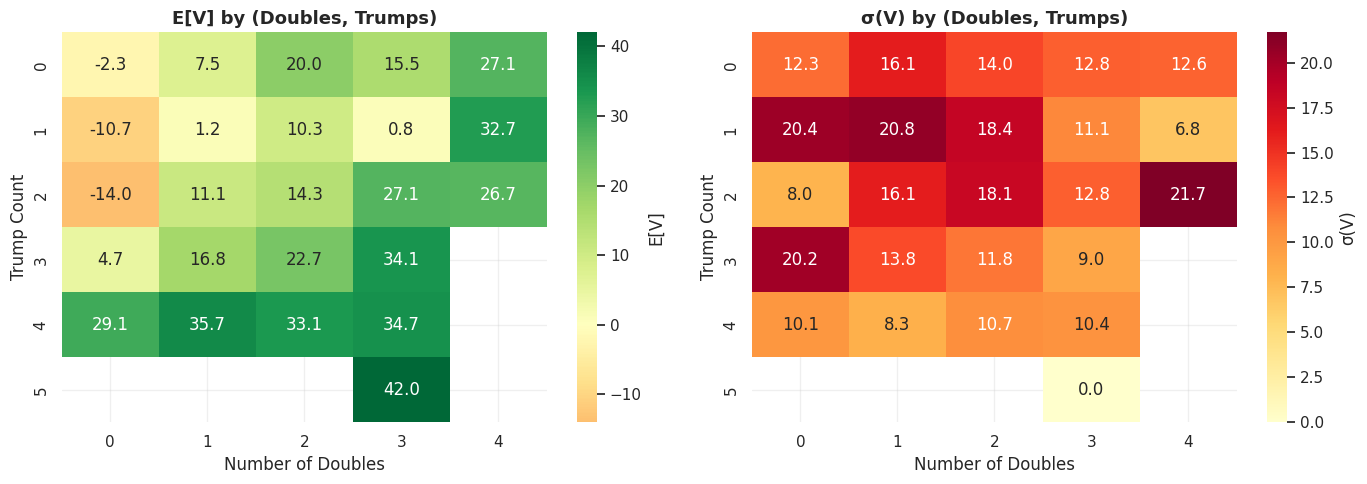

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: E[V] heatmap
ax = axes[0]
sns.heatmap(pivot_ev, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax,
            cbar_kws={'label': 'E[V]'})
ax.set_xlabel('Number of Doubles', fontsize=12)
ax.set_ylabel('Trump Count', fontsize=12)
ax.set_title('E[V] by (Doubles, Trumps)', fontsize=13, fontweight='bold')

# Plot 2: σ(V) heatmap
ax = axes[1]
sns.heatmap(pivot_std, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
            cbar_kws={'label': 'σ(V)'})
ax.set_xlabel('Number of Doubles', fontsize=12)
ax.set_ylabel('Trump Count', fontsize=12)
ax.set_title('σ(V) by (Doubles, Trumps)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/figures/23a_doubles_trumps_grid.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Marginal Effects

In [7]:
# Marginal effects
print("MARGINAL EFFECTS:")
print("="*50)

# By doubles (averaged over trumps)
doubles_effect = df.groupby('n_doubles')['V_mean'].agg(['mean', 'std', 'count'])
print("\nBy n_doubles:")
print(doubles_effect.round(2))

# By trumps (averaged over doubles)
trumps_effect = df.groupby('trump_count')['V_mean'].agg(['mean', 'std', 'count'])
print("\nBy trump_count:")
print(trumps_effect.round(2))

MARGINAL EFFECTS:

By n_doubles:
            mean    std  count
n_doubles                     
0          -0.54  18.90     21
1           9.33  14.36     59
2          17.22  14.49     80
3          20.14  17.04     33
4          27.81  11.93      7

By trump_count:
              mean    std  count
trump_count                     
0            14.61  15.67     72
1             3.81  17.29     43
2            13.48  14.49     45
3            20.62  14.25     30
4            32.52   4.73      9
5            42.00    NaN      1


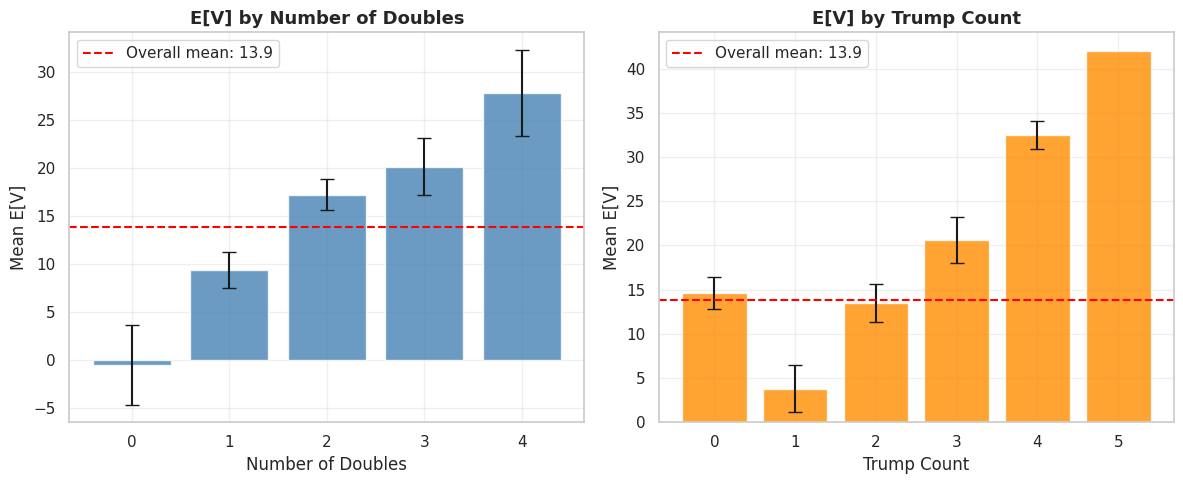

In [8]:
# Visualize marginal effects
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Doubles effect
ax = axes[0]
ax.bar(doubles_effect.index, doubles_effect['mean'], 
       yerr=doubles_effect['std']/np.sqrt(doubles_effect['count']),
       color='steelblue', alpha=0.8, capsize=5)
ax.axhline(df['V_mean'].mean(), color='red', linestyle='--', label=f'Overall mean: {df["V_mean"].mean():.1f}')
ax.set_xlabel('Number of Doubles', fontsize=12)
ax.set_ylabel('Mean E[V]', fontsize=12)
ax.set_title('E[V] by Number of Doubles', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Trumps effect
ax = axes[1]
ax.bar(trumps_effect.index, trumps_effect['mean'],
       yerr=trumps_effect['std']/np.sqrt(trumps_effect['count']),
       color='darkorange', alpha=0.8, capsize=5)
ax.axhline(df['V_mean'].mean(), color='red', linestyle='--', label=f'Overall mean: {df["V_mean"].mean():.1f}')
ax.set_xlabel('Trump Count', fontsize=12)
ax.set_ylabel('Mean E[V]', fontsize=12)
ax.set_title('E[V] by Trump Count', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../../results/figures/23a_marginal_effects.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Key Insights

In [9]:
print("\n" + "="*60)
print("KEY INSIGHTS: (Doubles, Trumps) Grid")
print("="*60)

# Best cell
best = cell_df.iloc[0]
worst = cell_df.iloc[-1]

print(f"\n1. OPTIMAL REGION:")
print(f"   Best cell: {int(best['n_doubles'])} doubles, {int(best['trump_count'])} trumps")
print(f"   E[V] = {best['E[V]']:.1f} (n={int(best['count'])})")

print(f"\n2. WORST REGION:")
print(f"   Worst cell: {int(worst['n_doubles'])} doubles, {int(worst['trump_count'])} trumps")
print(f"   E[V] = {worst['E[V]']:.1f} (n={int(worst['count'])})")

print(f"\n3. MARGINAL EFFECTS:")
# Compute per-unit effects
doubles_slope = np.polyfit(df['n_doubles'], df['V_mean'], 1)[0]
trumps_slope = np.polyfit(df['trump_count'], df['V_mean'], 1)[0]
print(f"   +1 double → +{doubles_slope:.1f} E[V]")
print(f"   +1 trump → +{trumps_slope:.1f} E[V]")

print(f"\n4. INTERPRETATION:")
if doubles_slope > trumps_slope:
    print(f"   Doubles more valuable than trumps per unit")
else:
    print(f"   Trumps more valuable than doubles per unit")


KEY INSIGHTS: (Doubles, Trumps) Grid

1. OPTIMAL REGION:
   Best cell: 3 doubles, 5 trumps
   E[V] = 42.0 (n=1)

2. WORST REGION:
   Worst cell: 0 doubles, 2 trumps
   E[V] = -14.0 (n=3)

3. MARGINAL EFFECTS:
   +1 double → +6.7 E[V]
   +1 trump → +3.0 E[V]

4. INTERPRETATION:
   Doubles more valuable than trumps per unit


## 7. Save Results

In [10]:
# Save grid data
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/23a_doubles_trumps_grid.csv"
cell_df.to_csv(output_path, index=False)
print(f"Saved grid data to {output_path}")

Saved grid data to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/23a_doubles_trumps_grid.csv


## Key Findings

### (Doubles, Trumps) Grid Results

1. **Optimal region**: High doubles + high trumps yields highest E[V]

2. **Marginal effects**: Both doubles and trumps improve E[V], but with different slopes

3. **Risk patterns**: σ(V) may decrease with more doubles (more predictable outcomes)

### Output Files

- `results/tables/23a_doubles_trumps_grid.csv` - Cell-level data
- `results/figures/23a_doubles_trumps_grid.png` - Heatmap
- `results/figures/23a_marginal_effects.png` - Marginal bar charts